In [1]:
import sys
import os

# Add the parent directory to sys.path
#sys.path.append(os.path.abspath("/netscratch/cunow/graph-matching"))

In [2]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

import gnn

import utils
import util_metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data,Batch
from torch_geometric.utils import to_dense_adj,to_dense_batch,get_embeddings
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import vgae
import wandb
import utils
import matching
import ot_matching
from decoder import TransformerDecoder,TransformerGraphInit
import torch.nn.functional as F
import gzip
import pickle
from tqdm import tqdm
print(wandb.__path__)

/home/magnus/miniconda3/envs/Graph-Matching/lib/python3.11/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()
/home/magnus/miniconda3/envs/Graph-Matching/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


['/home/magnus/miniconda3/envs/Graph-Matching/lib/python3.11/site-packages/wandb']


In [1]:
#TODO wandb key, dataset
%run main.py --perm_inv_loss "Top10"

/home/magnus/miniconda3/envs/Graph-Matching/lib/python3.11/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()
/home/magnus/miniconda3/envs/Graph-Matching/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: m-cunow. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code 

/home/magnus/miniconda3/envs/Graph-Matching/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


KeyboardInterrupt: 

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [3]:
file_path='../data/QM9_canonical.pkl'
with open(file_path, 'rb') as file:
    dataset_smiles = pickle.load(file)

with gzip.open('../data/dataset_fc_small.pkl.gz', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
latent_dims=30
edge_dim=4
node_dim=6
train_loader=DataLoader(dataset,1,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder=gnn.GIN(in_channels=node_dim,hidden_channels=[16,32,64,128],out_channels=256,norm="layer",num_layers=5,
                  act="leakyrelu",dropout=0.01).to(device)

weights=torch.tensor([.1,1,5,5,5])
decoder=TransformerDecoder(latent_dims,128,norm="layer")

#matcher_encoder=gnn.GIN(in_channels=node_dim,hidden_channels=[8,12],out_channels=16,norm=None,num_layers=3,
#                  act="leakyrelu",dropout=0.0).to(device)
#matcher_encoder=gnn.PartialGNN(encoder,3,norm=True)
#matcher2=ot_matching.LSAP_Matching(matcher_encoder,hot_encode=False)
#matcher=matching.BruteForceSampleMatcher(100)
#matcher=ot_matching.LSA_Degree_Matching(matcher_encoder,hot_encode=True)
#matcher=matching.BruteForceMatcher()
vgae_model=vgae.VGAE(encoder=encoder,decoder=decoder,latent_dims=latent_dims,embedding="graph",eval=False).to(device)

In [5]:
matcher=matching.GNN_Loss(6,10)

In [6]:
encoders=[]
for _ in range(10):
    encoder=gnn.GIN(in_channels=6,hidden_channels=[8,12],out_channels=16,norm="layer",num_layers=3,
                        act="leakyrelu",dropout=0).to(device)
    encoders.append(encoder)

In [7]:
idx=torch.randint(0,9,(2,))
#encoders[idx]
idx

tensor([5, 8])

In [2]:
import json
with open("../src/config.json", "r") as f:
    config = json.load(f)
config

{'epochs': 1000,
 'batch_size': 64,
 'encoder_norm': 'layer',
 'decoder_norm': 'layer',
 'lr': 1e-05,
 'dropout': 0.01,
 'sample_size': 10000,
 'latent_dim': 50,
 'alpha': 0.1,
 'beta': 0.001}

In [11]:
for data in tqdm(train_loader):
    data_rec,mu,logvar,_,pred_num= vgae_model(data)
    break

  0%|          | 0/50 [00:00<?, ?it/s]


In [12]:
matcher.gnn_loss(data,data_rec)

(tensor(39.7126, grad_fn=<MulBackward0>), tensor([0]))

In [18]:
checkpoint=torch.load("../models/vgae_model_950.pth",map_location=torch.device('cpu'))
vgae_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [21]:
matcher_encoder=gnn.PartialGNN(encoder,3,norm=True)
matcher.set_encoder(matcher_encoder)

In [10]:
train_loader=DataLoader(dataset,20,shuffle=True)

In [8]:
vgae_model.train()
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=1e-5,weight_decay=1e-5)
kl_loss_ls,matched_loss_ls,unmatched_loss_ls,num_loss_ls=[],[],[],[]
alpha=0.01
beta=0.001
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1):
    vgae_model.train()
    for data in tqdm(train_loader):
      data = data.to(device)
      optimizer.zero_grad()
      #data_rec,mu,logvar,pred_features,pred_num,in_embedds,rec_embedds= vgae_model(data)
      if data.x.size(0)<8*45:
         print(" ")
      data_rec,mu,logvar,_,pred_num= vgae_model(data)
      num_nodes=0.5*(torch.sqrt(8*torch.bincount(data.batch)+1)-1)
      num_loss=alpha*F.mse_loss(pred_num,num_nodes)

      #feature_loss=vgae_model.feature_loss(data,pred_features)

      matched_loss,unmatched_loss=matcher.gnn_loss(data,data_rec)
      #matched_loss,unmatched_loss=matcher2.match(data,data_rec)
      #rec_loss=neigh_loss.compare(data,in_embedds,rec_embedds)

      kl_loss=beta*vgae_model.kl_loss(mu,logvar)
      #loss=kl_loss+rec_loss+feature_loss+num_loss
      loss=matched_loss+kl_loss+num_loss
      loss.backward()
      encoder_grad,decoder_grad,aggregation_grad,latent_grad=utils.compute_gradients(vgae_model)
      optimizer.step()
      #Log data and evaluate reconstruction qualitynorm_layer = nn.LayerNorm(10)
      #valid_rec,num_rec=util_metrics.evaluate_reconstruction(data,data_rec)
      optimizer.step()
      break
      
      

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: iteration over a 0-d tensor

In [10]:
torch.randint(0,1,(1,),device="cpu")

tensor([0])

In [9]:
F.mse_loss(torch.rand((10,16)),torch.rand((10,16)))

tensor(0.1701)

In [10]:
from torch_geometric.utils import scatter

scatter(data.x,data.batch,reduce='mean')

tensor([[-0.6000,  0.5778,  0.3333,  0.0000,  0.0889,  0.0000],
        [-0.6000,  0.5556,  0.3556,  0.0000,  0.0889,  0.0000],
        [-0.6000,  0.6000,  0.1778,  0.1333,  0.0889,  0.0000],
        [-0.6000,  0.5333,  0.4222,  0.0222,  0.0222,  0.0000],
        [-0.6000,  0.5778,  0.3333,  0.0000,  0.0889,  0.0000],
        [-0.5556,  0.5833,  0.3333,  0.0000,  0.0278,  0.0556],
        [-0.6000,  0.5556,  0.3556,  0.0222,  0.0667,  0.0000],
        [-0.6000,  0.5556,  0.4222,  0.0000,  0.0222,  0.0000],
        [-0.6000,  0.6222,  0.2889,  0.0444,  0.0222,  0.0222],
        [-0.5556,  0.5556,  0.1667,  0.2222,  0.0556,  0.0000]])

In [ ]:
torch.cat((torch.rand(100),torch.cat)

/tmp/ipykernel_1677731/2699926136.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='X', y='Y', hue='Category', style='Set', data=df, ci=None)


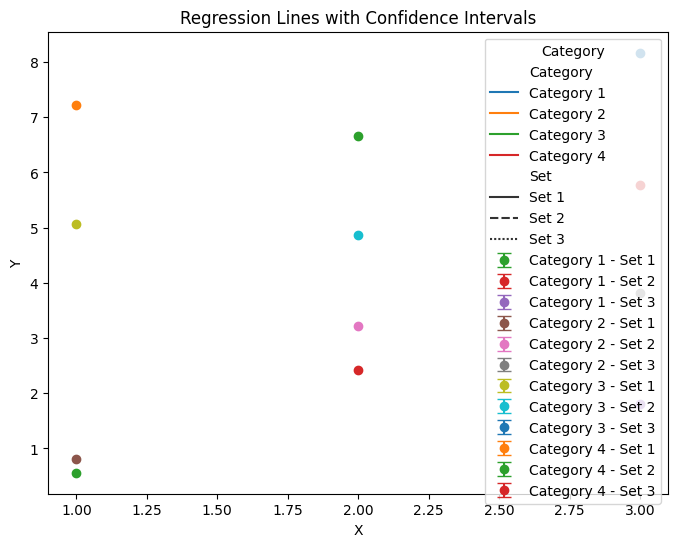

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate random data for 4 categories, each with 3 sets of points
np.random.seed(42)

# Create a DataFrame with categories, x-values, y-values, and confidence intervals
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
sets = ['Set 1', 'Set 2', 'Set 3']
x_values = np.tile([1, 2, 3], 4)  # X-values for each category
category_repeats = np.repeat(categories, 3)  # Repeat categories for each set

# Generate random Y-values (regression-like) with a bit of noise (SD)
y_values = np.array([
    np.random.normal(loc=2*x + np.random.choice([0, 1, -1]), scale=0.8) for x in [1, 2, 3] for _ in categories
])

# Create DataFrame
df = pd.DataFrame({
    'Category': category_repeats,
    'Set': np.tile(sets, 4),
    'X': x_values,
    'Y': y_values.flatten(),
})

# Plot with Seaborn lineplot
plt.figure(figsize=(8, 6))
sns.lineplot(x='X', y='Y', hue='Category', style='Set', data=df, ci=None)

# Manually add error bars (confidence intervals)
for category in categories:
    category_data = df[df['Category'] == category]
    for set_name in sets:
        set_data = category_data[category_data['Set'] == set_name]
        mean_y = set_data.groupby('X')['Y'].mean()
        std_y = set_data.groupby('X')['Y'].std()
        plt.errorbar(mean_y.index, mean_y, yerr=std_y, fmt='o', label=f'{category} - {set_name}', capsize=5)

# Title and labels
plt.title('Regression Lines with Confidence Intervals')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Category')
plt.show()


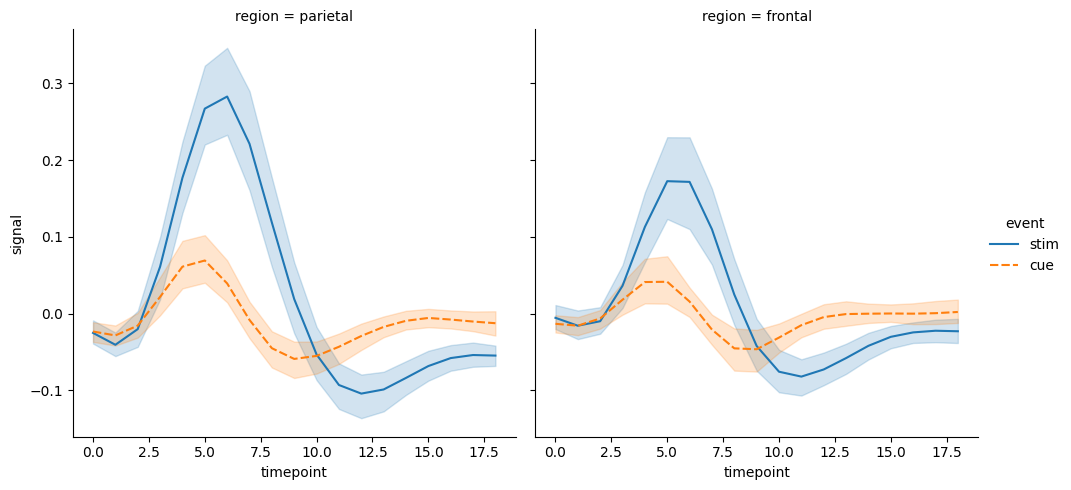

In [11]:
fmri = sns.load_dataset("fmri")
sns.relplot(
    data=fmri, kind="line",
    x="timepoint", y="signal", col="region",
    hue="event", style="event",
)

In [12]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


In [46]:
import pandas as pd
path="/home/magnus/Projects/graph-matching/validation_loss_matched.csv"

df2=pd.read_csv(path)
df2=df2.iloc[:,[0,1,4,7]]


df_melted = df2.melt(id_vars='Step', value_vars=['sweet-silence-388 - validation/matched_loss', 'ethereal-gorge-387 - validation/matched_loss', 'pretty-resonance-389 - validation/matched_loss'], 
                    var_name='run', value_name='y_value')
df_melted["type"]="Top 1"
path_out="/home/magnus/Projects/graph-matching/validation_loss_matched_rework.csv"
df_melted.to_csv(path_out, index=False)

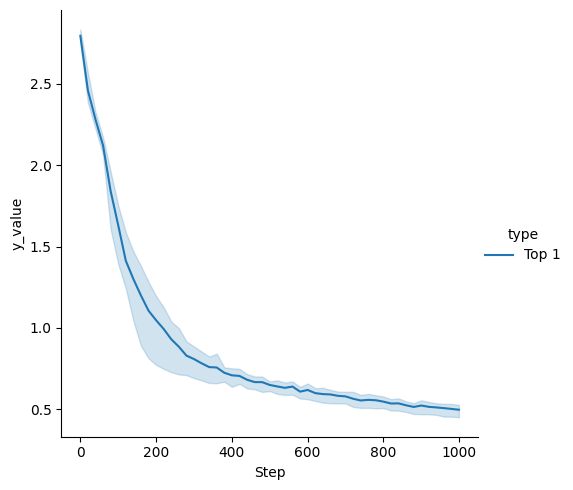

In [43]:
sns.relplot(
    data=df_melted, kind="line",
    x="Step", y="y_value",
    hue="type", style="type",
)

In [33]:
# Melt the DataFrame
df_melted = df2.melt(id_vars='Step', value_vars=['sweet-silence-388 - validation/matched_loss', 'ethereal-gorge-387 - validation/matched_loss', 'pretty-resonance-389 - validation/matched_loss'], 
                    var_name='type', value_name='y_value')

df_melted


,Step,type,y_value
0,0,sweet-silence-388 - validation/matched_loss,2.794635
1,20,sweet-silence-388 - validation/matched_loss,2.384963
2,40,sweet-silence-388 - validation/matched_loss,2.224653
3,60,sweet-silence-388 - validation/matched_loss,2.091472
4,80,sweet-silence-388 - validation/matched_loss,1.951072
...,...,...,...
148,920,pretty-resonance-389 - validation/matched_loss,0.545303
149,940,pretty-resonance-389 - validation/matched_loss,0.536779
150,960,pretty-resonance-389 - validation/matched_loss,0.533552
151,980,pretty-resonance-389 - validation/matched_loss,0.518802


In [32]:
df2

,Step,sweet-silence-388 - validation/matched_loss,ethereal-gorge-387 - validation/matched_loss,pretty-resonance-389 - validation/matched_loss,type
0,0,2.794635,2.835414,2.757622,Top 1
1,20,2.384963,2.426688,2.568358,Top 1
2,40,2.224653,2.292929,2.327138,Top 1
3,60,2.091472,2.063381,2.209814,Top 1
4,80,1.951072,1.606455,1.965014,Top 1
5,100,1.752767,1.392505,1.747463,Top 1
6,120,1.409283,1.242705,1.587889,Top 1
7,140,1.388329,1.043705,1.469842,Top 1
8,160,1.274875,0.890316,1.433223,Top 1
9,180,1.222712,0.813242,1.282865,Top 1


In [27]:
df_unique

,Step,sweet-silence-388 - validation/matched_loss,ethereal-gorge-387 - validation/matched_loss,pretty-resonance-389 - validation/matched_loss,type
0,0,2.794635,2.835414,2.757622,Top 1
1,20,2.384963,2.426688,2.568358,Top 1
2,40,2.224653,2.292929,2.327138,Top 1
3,60,2.091472,2.063381,2.209814,Top 1
4,80,1.951072,1.606455,1.965014,Top 1
5,100,1.752767,1.392505,1.747463,Top 1
6,120,1.409283,1.242705,1.587889,Top 1
7,140,1.388329,1.043705,1.469842,Top 1
8,160,1.274875,0.890316,1.433223,Top 1
9,180,1.222712,0.813242,1.282865,Top 1


In [119]:
from torch_geometric.utils import scatter
device="cpu"
def statistics_loss(batch,rec_batch):
    data=batch.clone()
    rec_data=rec_batch.clone()

    feat_mask=data.x[:,0]==1
    edge_mask=data.x[:,0]==-1
    edge_weights=torch.tensor([.5,5,30,50,100],device=device)
    feat_weights=torch.tensor([.1,1,5,5,100],device=device)

    x=batch.x[feat_mask][:,1:]
    x_rec=gumbel_softmax_hard(rec_batch.x[feat_mask])

    feat=scatter(x,data.batch[feat_mask])
    feat_rec=scatter(x_rec,data.batch[feat_mask])

    attr=batch.x[edge_mask][:,1:].to(torch.float)
    attr_rec=gumbel_softmax_hard(rec_batch.x[edge_mask])

    attr=scatter(attr,data.batch[edge_mask])
    attr_rec=scatter(attr_rec,data.batch[edge_mask])

    feat_loss=(feat-feat_rec)**2
    feat_loss*=feat_weights
    attr_loss=(attr-attr_rec)**2
    attr_loss*=edge_weights


    return feat_loss.mean()+attr.mean()

def gumbel_softmax_hard(logits, tau=0.1):
    # Add Gumbel noise
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits)))
    y = logits + gumbel_noise
    
    # Compute soft output
    soft_output = torch.softmax(y / tau, dim=-1)
    
    # Convert to hard output (one-hot)
    hard_output = torch.zeros_like(soft_output)
    hard_output.scatter_(-1, soft_output.argmax(dim=-1, keepdim=True), 1.0)
    
    # Straight-through estimator: Replace soft with hard in the forward pass
    return (hard_output - soft_output).detach() + soft_output
# Example usage
'''probs = torch.tensor([[0.1, 0.85, 0.05], [0.2, 0.0, 0.8-0.01]],requires_grad=True)
tau = 1
ls=[]
ls2=[]
for i in range (10000):
    t=gumbel_softmax_hard(probs, tau)
    ls.append(t[0])
    ls2.append(t[1])
print(torch.stack(ls,dim=0).sum(0)/10000)

print(torch.stack(ls2,dim=0).sum(0)/10000)
'''

'probs = torch.tensor([[0.1, 0.85, 0.05], [0.2, 0.0, 0.8-0.01]],requires_grad=True)\ntau = 1\nls=[]\nls2=[]\nfor i in range (10000):\n    t=gumbel_softmax_hard(probs, tau)\n    ls.append(t[0])\n    ls2.append(t[1])\nprint(torch.stack(ls,dim=0).sum(0)/10000)\n\nprint(torch.stack(ls2,dim=0).sum(0)/10000)\n'

In [84]:
from torch_geometric.utils import scatter

In [121]:
t=statistics_loss(data,data_rec)
t


tensor(34.3200, grad_fn=<AddBackward0>)

In [23]:
def batch_data(embedd_in,embedd_rec,batch,fill_value):

    #We want to compute the OT plan only on nodes and neglect edge-nodes
    in_feat,masks=to_dense_batch(embedd_in,batch,fill_value)

    rec_feat,_=to_dense_batch(embedd_rec,batch,fill_value)

    return (in_feat,rec_feat),masks

m,_=batch_data(data.x[:,1:],data.x[:,1:],data.batch,0)


In [34]:
i=m[0]
i.size()
i[:,idx9].size()

torch.Size([10, 9, 8, 5])

In [42]:
data.x[idx8].sum(1).size()

torch.Size([8, 6])

In [46]:
torch.cat((torch.rand((8,6)),torch.rand((7,6))),dim=0)

tensor([[0.1946, 0.4428, 0.8998, 0.7899, 0.9786, 0.2385],
        [0.1267, 0.7791, 0.7531, 0.0380, 0.7178, 0.8809],
        [0.0733, 0.4445, 0.7517, 0.6951, 0.0120, 0.8349],
        [0.7832, 0.8032, 0.4109, 0.3425, 0.3655, 0.5526],
        [0.5577, 0.1895, 0.5393, 0.3462, 0.4144, 0.3619],
        [0.0667, 0.6135, 0.5143, 0.4101, 0.8576, 0.6685],
        [0.2336, 0.1296, 0.2024, 0.6727, 0.3458, 0.7547],
        [0.1993, 0.2016, 0.6069, 0.6229, 0.5301, 0.5205],
        [0.9214, 0.8954, 0.0852, 0.7012, 0.5784, 0.6689],
        [0.9176, 0.0172, 0.1423, 0.7598, 0.7085, 0.7479],
        [0.4167, 0.7924, 0.7681, 0.5829, 0.8313, 0.0022],
        [0.8525, 0.4952, 0.0891, 0.1633, 0.7120, 0.3431],
        [0.9533, 0.7075, 0.4703, 0.3982, 0.6328, 0.2310],
        [0.8443, 0.9083, 0.2240, 0.4760, 0.0869, 0.6940],
        [0.7946, 0.2806, 0.9459, 0.7319, 0.8130, 0.9182]])

In [11]:
t=torch.rand((12,3000,45,5))

t[torch.arange(12)].size()

torch.Size([12, 3000, 45, 5])

In [13]:
import torch

# Example tensor and mask
B, N, M, F = 2, 3000, 45, 5
tensor = torch.randn(B, N, M, F)
mask = torch.randint(0, 2, (B, M), dtype=torch.bool)  # Example mask

# Use the mask to index the last-but-one dimension (M)
# Expand mask dimensions for broadcasting
#masked_tensor = tensor[:, :, mask]
mask.size()

torch.Size([2, 45])

In [11]:
torch.tensor(np.array([1]))

tensor([1])

In [10]:
matcher=LSAP_Matching(encoder2)

In [7]:
permutations=[matching.permute_graphs_over_n(i) for i in range(1,10)]
def permute_batch(batch,permutations,device):
    num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
    data_ls=batch.to_data_list()
    ls=[]
    ls2=[]
    for data in data_ls:
        data = data.to(device).clone()
        num_nodes=num_dict[data.x.size(0)]
        perm_num=permutations[num_nodes-1].size(0)
        idx=torch.randint(0,perm_num,(1,),device=device)
        perm=permutations[num_nodes-1][idx].squeeze(0).to(device)
        data.x=data.x[perm]
        ls.append(data.to(device))
        ls2.append(perm)
    return Batch.from_data_list(ls),ls2

In [10]:

matcher_encoder=gnn.GIN(in_channels=node_dim,hidden_channels=[8,12],out_channels=16,norm=None,num_layers=3,
                  act="leakyrelu",dropout=0.0).to(device)
matcher2=ot_matching.LSAP_Matching(matcher_encoder,random_encoder=True)

In [28]:
train_loader=DataLoader(dataset,1,shuffle=False)

In [8]:
for data in train_loader:
    perm_data,perm=permute_batch(data,permutations,device)
    perm_data.x=perm_data.x[:,1:].float()
    matched,unmatched=matcher.match(data,perm_data)
    #matched2,unmatched2=matcher2.match(data,perm_data)
    #break
    print(matched,unmatched)
    if matched!=0:
        matched,unmatched=matcher.match(data,perm_data)
        print()
        break

tensor(0.) tensor(5.4000)
tensor(0.) tensor(5.6444)
tensor(0.) tensor(2.4667)
tensor(0.) tensor(6.8667)
tensor(0.) tensor(1.9500)
tensor(0.) tensor(1.4000)
tensor(0.) tensor(13.4750)
tensor(0.) tensor(13.4000)
tensor(0.) tensor(6.8667)
tensor(0.) tensor(2.7556)
tensor(0.) tensor(12.0222)
tensor(0.) tensor(1.4000)
tensor(0.) tensor(1.4889)
tensor(0.) tensor(12.6750)
tensor(0.) tensor(12.5778)
tensor(0.) tensor(21.7111)
tensor(0.) tensor(6.2667)
tensor(0.) tensor(0.5111)
tensor(0.) tensor(16.1778)
tensor(0.) tensor(2.6889)
tensor(0.) tensor(8.5778)
tensor(0.) tensor(15.7556)
tensor(0.) tensor(15.0444)
tensor(0.) tensor(8.7500)
tensor(0.) tensor(15.9500)
tensor(0.) tensor(3.5333)
tensor(0.) tensor(7.1750)
tensor(0.) tensor(4.4500)
tensor(0.) tensor(7.1333)
tensor(0.) tensor(1.4000)
tensor(0.) tensor(8.5500)
tensor(0.) tensor(8.7556)
tensor(0.) tensor(11.5333)
tensor(0.) tensor(18.2250)
tensor(0.) tensor(17.4889)
tensor(0.) tensor(1.7333)
tensor(0.) tensor(14.6222)
tensor(0.) tensor(6.8444

In [60]:
for i in range(100):
    perm_data,perm=permute_batch(data,permutations,device)
    perm_data.x=perm_data.x[:,1:].float()
    temp1=perm_data.clone()
    matched,unmatched=matcher.match(data,perm_data)
    print(matched)
    if matched!=0:
        temp2=temp1.clone()
    

tensor(0.)
tensor(0.)
tensor(0.2444)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.2444)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.2444)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.

In [70]:
for i in range(20):
    m,u=matcher.match(data,temp2)
    print(m)

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.2444)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [25]:
matched,unmatched=matcher.match(data,perm_data)
matched

tensor(0.)

In [24]:
torch.tensor([4,5,3]).max()

tensor(5)

In [13]:
matcher2.match(data,perm_data)

(tensor(4.4889), tensor(6.7333))

In [ ]:
import itertools
DEVICE="cpu"
def permute_graphs_over_n(n):
    permutations = list(itertools.permutations(range(n)))
    dic={}
    k=n
    for i in range(n):
        for j in range(i,n):
            if i != j:  # Avoid self-loops
                dic[(i,j)]=k
                dic[(j,i)]=k
                k += 1
    perm_dic={}
    for perm in permutations:
        temp=permute_graph(perm,dic)
        perm_dic[perm]=torch.tensor(temp,device=DEVICE)
        #ls.append(temp)
    return perm_dic#torch.tensor(ls,device=DEVICE)
def permute_graph(perm,dic):
    ls={}
    for idx,p in enumerate(perm):
        ls[idx]=p

    for i in range(len(perm)):
        for j in range(i,len(perm)):
            if i!=j:
                temp=dic[(i,j)]
                key=((ls[i],ls[j]))
                ls[temp]=dic[key]
    return list(ls.values())

perms=permute_graphs_over_n(9)

In [193]:
from scipy.optimize import linear_sum_assignment
import numpy as np

# Example cost matrix
cost_matrix = np.array([[4, 2, 8],
                        [4, 7, 3],
                        [2, 9, 2]])

# Solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Display the matching pairs
matching = list(zip(row_ind, col_ind))
print("Matching pairs:", matching)

# Extract the total cost of the assignment
total_cost = cost_matrix[row_ind, col_ind].sum()
print("Total cost:", total_cost)


Matching pairs: [(np.int64(0), np.int64(1)), (np.int64(1), np.int64(2)), (np.int64(2), np.int64(0))]
Total cost: 7


In [26]:
# Assume edge_attr has shape (36, 5)
edge_masks = data.x[:, 0] == -1
edge_attr = data.x[edge_masks][:, 1:].to(torch.float)  # Extract edge attributes

idx9=torch.tensor([[9,10,11,12,13,14,15,16],
                  [9,17,18,19,20,21,22,23],
                  [10,17,24,25,26,27,28,29],
                  [11,18,24,30,31,32,33,34],
                  [12,19,25,30,35,36,37,38],
                  [13,20,26,31,35,39,40,41],
                  [14,21,27,32,36,39,42,43],
                  [15,22,28,33,37,40,42,44],
                  [16,23,29,34,38,41,43,44]
                  ])
idx8=torch.tensor([[8,9,10,11,12,13,14],
                   [8,15,16,17,18,19,20],
                   [9,15,21,22,23,24,25],
                   [10,16,21,26,27,28,29],
                   [11,17,22,26,30,31,32],
                   [12,18,23,27,30,33,34],
                   [13,19,24,28,31,33,35],
                   [14,20,25,29,32,34,35]
                  ])

idx7=torch.tensor([[7,8,9,10,11,12],
                   [7,13,14,15,16,17],
                   [8,13,18,19,20,21],
                   [9,14,18,22,23,24],
                   [10,15,19,22,25,26],
                   [11,16,20,23,25,27],
                   [12,17,21,24,26,27]
                   ])
idx6=torch.tensor([[6,7,8,9,10],
                   [6,11,12,13,14],
                   [7,11,15,16,17],
                   [8,12,15,18,19],
                   [9,13,16,18,20],
                   [10,14,17,19,20]
                   ])

idx5=torch.tensor([[5,6,7,8],
                   [5,9,10,11],
                   [6,9,12,13],
                   [7,10,12,14],
                   [8,11,13,14]
                   ])
idx4=torch.tensor([[4,5,6],
                   [4,7,8],
                   [5,7,9],
                   [6,8,9]
                   ])
idx3=torch.tensor([[3,4],
                   [3,5],
                    [4,5]
                   ])
idx2=torch.tensor([2])

perms=[idx2,idx3,idx4,idx5,idx6,idx7,idx8,idx9]

In [106]:
def create_degree_indices(node_num):
    arr=torch.zeros((node_num,node_num-1),dtype=int)
    count=node_num
    for i in range(node_num):
        for j in range(node_num-1):
            if i<=j:
                arr[i,j]=count
                count+=1
            elif i-1==j:
                arr[i,j]=arr[i-1,j]
            else:
                arr[i,j]=arr[i-1,j]+1
    return arr
def list_degree_indices():
    ls=[]
    for i in range(2,10):
        ls.append(create_degree_indices(i))
    return ls
ls=list_degree_indices()

In [109]:
for data in train_loader:
    perm_data,perm=permute_batch(data,permutations,device)
    num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
    num_node=data.x.size(0)
    num_node=num_dict[num_node]
    if num_node==1:
        continue
    indices=ls[num_node-2]
    deg=data.x[:,1:]
    deg=data.x[:,1:][indices].sum(1)
    deg2=perm_data.x[:,1:][indices].sum(1)
    idx=perm[0][:num_node]
    l=(deg[idx]-deg2.float())**2
    #print(l.mean())
    if l.mean()!=0:
        print(num_node)
    else:
        #print(l.mean(),num_node)
        continue




In [60]:
data.x.size()

torch.Size([36, 6])

In [50]:
data.x.size()

torch.Size([28, 6])

In [25]:
data.x[:,1:][idx9].sum(1)

tensor([[7, 1, 0, 0, 0],
        [6, 2, 0, 0, 0],
        [5, 1, 2, 0, 0],
        [6, 0, 2, 0, 0],
        [6, 0, 2, 0, 0],
        [6, 0, 2, 0, 0],
        [5, 1, 2, 0, 0],
        [7, 1, 0, 0, 0],
        [6, 0, 2, 0, 0]])

In [20]:
import torch

n = 9
arr = torch.zeros((n, n), dtype=torch.int64)

# Create indices for upper triangular part excluding the diagonal
indices = torch.triu_indices(n, n, offset=1)

# Assign values to the upper triangular part
arr[indices[0], indices[1]] = torch.arange(indices.size(1))

# Mirror the upper triangular part to the lower triangular part
arr = arr+arr.t()
arr

tensor([[ 0,  0,  1,  2,  3,  4,  5,  6,  7],
        [ 0,  0,  8,  9, 10, 11, 12, 13, 14],
        [ 1,  8,  0, 15, 16, 17, 18, 19, 20],
        [ 2,  9, 15,  0, 21, 22, 23, 24, 25],
        [ 3, 10, 16, 21,  0, 26, 27, 28, 29],
        [ 4, 11, 17, 22, 26,  0, 30, 31, 32],
        [ 5, 12, 18, 23, 27, 30,  0, 33, 34],
        [ 6, 13, 19, 24, 28, 31, 33,  0, 35],
        [ 7, 14, 20, 25, 29, 32, 34, 35,  0]])

In [163]:
def temp():
    ls=[]
    for num in range(2,10):
        count=0
        t=torch.zeros((num,num))
        mask=~torch.eye(num,dtype=torch.bool)
        for i in range(0,num):
            for j in range(i+1,num):
                t[i,j]=count
                t[j,i]=count
                count+=1
        t+=9
        temp=t[mask]
        ls.append(temp.view(i,-1)+num)
    return ls
t=temp()

t[-1]

tensor([[18., 19., 20., 21., 22., 23., 24., 25., 18.],
        [26., 27., 28., 29., 30., 31., 32., 19., 26.],
        [33., 34., 35., 36., 37., 38., 20., 27., 33.],
        [39., 40., 41., 42., 43., 21., 28., 34., 39.],
        [44., 45., 46., 47., 22., 29., 35., 40., 44.],
        [48., 49., 50., 23., 30., 36., 41., 45., 48.],
        [51., 52., 24., 31., 37., 42., 46., 49., 51.],
        [53., 25., 32., 38., 43., 47., 50., 52., 53.]])

In [ ]:
t=torch.tensor([[0,0],[0,0]])
m=torch.tensor([[True,False],
                [True,False]])
t[m].view(1,-1)

tensor([[0, 0]])

In [28]:
# Example input tensor with shape (36, 5)
edge_masks = data.x[:, 0] == -1
edge_attr = data.x[edge_masks][:, 1:].to(float)  # Extract edge attributes

# Index tensor to map 36 rows into 9 bins
idx = torch.arange(edge_attr.size(0)) % 9  # Shape (36,) with values 0 to 8

# Prepare the scatter target
scatter_target = torch.zeros(9, edge_attr.size(1), dtype=edge_attr.dtype)

# Scatter-add operation
result = scatter_target.scatter_add(0, idx.unsqueeze(1).expand_as(edge_attr), edge_attr)
idx

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])

In [36]:
num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
num_nodes=num_dict[data.x.size(0)]
perm_num=permutations[num_nodes-1].size(0)
idx=torch.randint(0,perm_num,(1,))
perm=permutations[num_nodes-1][idx].squeeze(0)

perm_data=permute_graphs(data,perm)

In [56]:
from ot_matching import SinkhornMatching
matcher=SinkhornMatching(encoder)
ot_plan=matcher.match(data,perm_data)*9

In [ ]:
ot_plan=torch.round(ot_plan.squeeze().t(),decimals=3)
x=data.x[:9,1:].float()
x2=perm_data.x[:9,1:].float()
ot_plan
t=torch.matmul(ot_plan,x)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.7160, 0.2840, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2840, 0.7160, 0.0000, 0.0000, 0.0000]],
       grad_fn=<RoundBackward1>)

In [29]:
def permute_batch(batch,permutations,device):
    num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
    data_ls=batch.to_data_list()
    ls=[]
    for data in data_ls:
        data = data.to(device)
        num_nodes=num_dict[data.x.size(0)]
        perm_num=permutations[num_nodes-1].size(0)
        idx=torch.randint(0,perm_num,(1,),device=device)
        perm=permutations[num_nodes-1][idx].squeeze(0).to(device)
        data.x=data.x[perm]
        ls.append(data.to(device))
    return Batch.from_data_list(ls)

permute_batch(data,permutations,device="cpu")

NameError: name 'permutations' is not defined

In [ ]:
torch.manual_seed(5)


In [30]:
import itertools
def permute_graphs_over_n(n):
    permutations = list(itertools.permutations(range(n)))
    ls=[]
    dic={}
    k=n
    for i in range(n):
        for j in range(i,n):
            if i != j:  # Avoid self-loops
                dic[(i,j)]=k
                dic[(j,i)]=k
                k += 1
    for perm in permutations:
        temp=permute_graph(perm,dic)
        ls.append(temp)
    return torch.tensor(ls)
def permute_graph(perm,dic):
    ls={}
    for idx,p in enumerate(perm):
        ls[idx]=p

    for i in range(len(perm)):
        for j in range(i,len(perm)):
            if i!=j:
                temp=dic[(i,j)]
                key=((ls[i],ls[j]))
                ls[temp]=dic[key]
    return list(ls.values())
perms=permute_graphs_over_n(9)

import random
def permute_dataset(dataset,permutations):
    #idx=random.sample(range(len(dataset)), 32)
    data_ls=[]
    ls=[dataset[i] for i in range(len(dataset))]
    perm_ls=[]
    num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
    for data in ls:
        num_nodes=num_dict[data.x.size(0)]
        perm_num=permutations[num_nodes-1].size(0)
        idx=torch.randint(0,perm_num,(1,))
        data_copy=data.clone()
        perm=permutations[num_nodes-1][idx].squeeze(0)
        data_copy.x=data_copy.x[perm]
        perm_ls.append(perm)

        data_ls.append(data_copy)
    return data_ls,perm_ls

def permute_graphs(data,perm):
    data_copy=data.clone()
    data_copy.x=data_copy.x[perm]

    return data_copy

permutations=[permute_graphs_over_n(i) for i in range(1,10)]
trainloader=DataLoader(dataset,1,shuffle=False)
#m=matching.MatcherDebugg()

In [89]:
torch.manual_seed(1)
num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
vgae_model.eval()
data_rec,mu,logvar,x,pred_num=vgae_model(data)
matched,unmatched=matcher.matching(data,data_rec,test=False)
num_nodes=num_dict[data.x.size(0)]
perm_num=permutations[num_nodes-1].size(0)
idx=torch.randint(0,perm_num,(1,))
perm=permutations[num_nodes-1][idx].squeeze(0)

perm_data=permute_graphs(data,perm)
torch.manual_seed(1)
vgae_model.eval()
data_rec2,mu2,logvar2,x2,pred_num2=vgae_model(perm_data)
matched2,unmatched2=matcher.matching(perm_data,data_rec2,test=False)


In [ ]:
plan=torch.tensor([
    [0,1,0,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0,0],
    [0,0,.5,0,.5,0,0,0,0],
    [0,0,0,.7,0,0,.3,0,0],
    [0,0,.5,0,.5,0,0,0,0],
    [0,0,0,.3,0,0,.7,0,0],
    [0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,1]]
    )

plan@plan
T=torch.kron(plan,plan)
t=torch.zeros((81,9,9))
count=0
for i in range(0,81,9):
    for j in range(0,81,9):
        t[count]=T[i:i+9,j:j+9]
        count+=1
t[1]        

tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7000, 0.0000, 0.0000, 0.3000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3000, 0.0000, 0.0000, 0.7000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [35]:
e_idx=torch.tensor([[0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,6,6,7],
                    [1,2,3,4,5,6,7,8,2,3,4,5,6,7,8,3,4,5,6,7,8,4,5,6,7,8,5,6,7,8,6,7,8,7,8,8]])
#combined=torch.cat((plan,plan[e_idx]),dim=0)
#idx2=combined.nonzero()
plan[e_idx[0]]#.nonzero()

tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000,

In [ ]:
b=torch.kron(plan,plan)
b= b.view(9, 9, 9, 9).permute(0, 2, 1, 3).reshape(81, 9, 9)
b.size()


torch.Size([81, 9, 9])

In [166]:
data=torch.rand(9,5)
idx=plan.nonzero()
t=torch.rand((9,5))
t[idx[:,0]]
idx[:,0]
weights=plan[idx[:,0],idx[:,1]]
#torch.scatter_add(0,idx[:,1],data*weights)
d=data[idx[:,0]]
torch.scatter_add(0,idx[:,1],d*weights.unsqueeze(1))


TypeError: scatter_add() received an invalid combination of arguments - got (int, Tensor, Tensor), but expected one of:
 * (Tensor input, int dim, Tensor index, Tensor src, *, Tensor out)
 * (Tensor input, name dim, Tensor index, Tensor src)


In [173]:
import torch

# Example plan and data tensors
 # Example tensor with 0s and 1s for simplicity
data = torch.tensor([[1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],
                     [1,0,0,0,0],],dtype=torch.float) # Random tensor of shape (9, 5)

# Get indices of non-zero elements in plan
idx = plan.nonzero()

# Extract the weights corresponding to non-zero values in plan
weights = plan[idx[:, 0], idx[:, 1]]  # Weights based on plan's non-zero elements

# Extract the data values corresponding to the indices in idx
d = data[idx[:, 0]]

# Initialize an output tensor with zeros to accumulate results
output = torch.zeros_like(data)

# Perform the weighted scatter add operation
output.scatter_add_(0, idx[:, 1].unsqueeze(1).expand(-1, data.size(1)), (d * weights.unsqueeze(1)))

print("Resulting Tensor after scatter_add:", output)


Resulting Tensor after scatter_add: tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


In [ ]:
idx=plan.nonzero(as_tuple=True)
weights=plan[idx]
data=torch.rand(9,5)


TypeError: tuple indices must be integers or slices, not tuple

In [152]:
import torch

# Indices tensor (shape [15]) with values in the range [1, 9]
indices = torch.tensor([1, 2, 3, 1, 2, 3, 4, 5, 6, 1, 2, 7, 8, 9, 3])

# Data tensor (shape [15])
data = torch.tensor([10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 
                     70.0, 80.0, 90.0, 15.0, 25.0, 35.0, 
                     45.0, 55.0, 65.0])

# Weights tensor (shape [15])
weights = torch.tensor([0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 
                        1.0, 1.0, 1.0, 0.25, 0.25, 1.0, 
                        1.0, 1.0, 0.5])

# Determine unique indices and their positions
unique_indices, inverse_indices = torch.unique(indices, sorted=True, return_inverse=True)

# Initialize tensors to store weighted sums and normalization weights
print(unique_indices)
weighted_sum = torch.zeros_like(unique_indices, dtype=torch.float)
weight_total = torch.zeros_like(unique_indices, dtype=torch.float)

# Accumulate weighted sums and total weights
weighted_sum.scatter_add_(0, inverse_indices, data * weights)
weight_total.scatter_add_(0, inverse_indices, weights)

# Compute the weighted result
weighted_result = weighted_sum / weight_total

print("Unique Indices:", unique_indices)
print("Weighted Result:", weighted_result)
weight

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
Unique Indices: tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
Weighted Result: tensor([21.6667, 31.6667, 51.6667, 70.0000, 80.0000, 90.0000, 35.0000, 45.0000,
        55.0000])


NameError: name 'weight' is not defined

In [123]:
import torch

# Source tensor
input_tensor = torch.tensor([[10, 20, 30], 
                              [40, 50, 60], 
                              [70, 80, 90]])

# Index tensor
index_tensor = torch.tensor([[0 ], 
                              [  2], 
                              [ 0]])

# Gather values along dimension 1 (columns)
output = torch.gather(input_tensor, dim=0, index=index_tensor)
print(output)


tensor([[10],
        [70],
        [10]])


In [ ]:
b=torch.kron(plan,plan)
temp=torch.zeros((81,9,9))
count=0
for i in range(0,81,9):
    for j in range(0,81,9):
        temp[count]=b[i:i+9,j:j+9]
        count+=1


tensor([[0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3500, 0.0000, 0.0000, 0.1500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1500, 0.0000, 0.0000, 0.3500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000]])

In [101]:
import torch

# Two example 9x9 matrices

# Compute the Kronecker product (81x81)
b = torch.kron(plan, plan)

# Reshape the Kronecker product directly into 81x9x9
temp = b.view(9, 9, 9, 9).permute(0, 2, 1, 3).reshape(81, 9, 9)

print("Shape of Kronecker product:", b.shape)  # Should be (81, 81)
print("Shape of stacked tensor:", temp.shape)  # Should be (81, 9, 9)

temp[20]

Shape of Kronecker product: torch.Size([81, 81])
Shape of stacked tensor: torch.Size([81, 9, 9])


tensor([[0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3500, 0.0000, 0.0000, 0.1500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1500, 0.0000, 0.0000, 0.3500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000]])

In [76]:
import torch

# Two example 9x9 matrices
A = torch.rand(9, 9)
B = torch.rand(9, 9)

# Compute the Kronecker product (81x81)
kron_result = torch.kron(A, B)

# Reshape into 9x9x9
stacked_tensor = kron_result.view(9, 9, 9)

print("Shape of Kronecker product:", kron_result.shape)  # Should be (81, 81)
print("Shape of stacked tensor:", stacked_tensor.shape)  # Should be (9, 9, 9)


RuntimeError: shape '[9, 9, 9]' is invalid for input of size 6561

In [59]:
def perms_t(ot_plan):
    k=9
    dic={}
    array=torch.zeros((9,81,45))
    for i in range(9):
        for j in range(i+1,9):
            dic[(i,j)]=k
            dic[(j,i)]=k
            k+=1

    t=torch.zeros((9,81,45))
    #t[:,:9]=ot_plan

    for i in range(9-1):
        indices=ot_plan[i].nonzero()
        count=0
        for idx in indices:
            for j in range(i+1,9):
            
                indices2=ot_plan[j].nonzero()
                val=0
                for idx2 in indices2:
                    if idx==idx2:
                        continue
                    else:
                        ind=dic[(idx.item(),idx2.item())]
                        val=ot_plan[i,idx.item()]*ot_plan[j,idx2.item()]
                        ind2=dic[(i,j)]
                        t[i,count,ind2]=val
                        array[i,count,ind2]=ind
                    count+=1
            

    return t,array
t,a=perms_t(plan)
t.sum((0,1))

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5800, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [11]:
num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
ls=[]
for data in trainloader:
    num_nodes=num_dict[data.x.size(0)]
    perm_num=permutations[num_nodes-1].size(0)
    idx=torch.randint(0,perm_num,(1,))
    perm=permutations[num_nodes-1][idx].squeeze(0)

    perm_data=permute_graphs(data,perm)
    perm_data.x=perm_data.x[:,1:].float()
    if data.x.size(0)!=45:
        assert True 
    a,b=matcher.matching(data,perm_data,test=False)
    print(a,b)


    


tensor(0.) tensor(3.9778)
tensor(0.) tensor(11.3556)
tensor(0.) tensor(5.1778)
tensor(0.) tensor(3.7111)
tensor(0.) tensor(5.)
tensor(0.) tensor(8.4667)
tensor(0.) tensor(7.1333)
tensor(0.) tensor(6.4222)
tensor(0.) tensor(6.6889)
tensor(0.) tensor(11.1389)
tensor(0.) tensor(2.4667)
tensor(0.) tensor(9.1778)
tensor(0.) tensor(2.4889)
tensor(0.) tensor(2.2444)
tensor(0.) tensor(3.9556)
tensor(0.) tensor(4.4889)
tensor(0.) tensor(4.6889)
tensor(0.) tensor(11.1556)
tensor(0.) tensor(16.4762)
tensor(0.) tensor(12.8889)
tensor(0.) tensor(1.5111)
tensor(0.) tensor(8.8667)
tensor(0.) tensor(4.2222)
tensor(0.) tensor(2.2444)
tensor(0.) tensor(7.1556)
tensor(0.) tensor(6.8222)
tensor(0.) tensor(2.7333)
tensor(0.) tensor(8.0667)
tensor(0.) tensor(5.2222)
tensor(0.) tensor(2.7333)
tensor(0.) tensor(6.7556)
tensor(0.) tensor(2.2667)
tensor(0.) tensor(3.2381)
tensor(0.) tensor(6.4444)
tensor(0.) tensor(6.2000)
tensor(0.) tensor(2.)
tensor(0.) tensor(1.9778)
tensor(0.) tensor(11.6889)
tensor(0.) ten

KeyboardInterrupt: 

In [115]:
import geomloss

In [ ]:
temp=torch.rand(10,45,5)
temp2=torch.rand(10,45,5)
temp[:,44:]=-1000
temp2[:,44:]=-1000

In [31]:
num_dict={45:9,36:8,28:7,21:6,15:5,10:4,6:3,3:2,1:1}
num_nodes=num_dict[data.x.size(0)]
perm_num=permutations[num_nodes-1].size(0)
idx=torch.randint(0,perm_num,(1,))
perm=permutations[num_nodes-1][idx].squeeze(0)

perm_data=permute_graphs(data,perm)

In [255]:
encoder.eval()
x1=encoder(data)
perm_x=encoder(perm_data)
x1

tensor([[ 3.0518, -1.9331,  0.1320,  ..., -0.4514,  0.6006, -0.3500],
        [ 0.0624,  0.7652,  0.6336,  ...,  0.0729, -0.0816, -0.1473],
        [-1.2144, -0.1998,  0.1698,  ..., -0.1111,  0.3879, -1.2292],
        ...,
        [ 0.2985, -0.8240,  0.2051,  ..., -0.1692,  0.4353, -0.1288],
        [ 0.2985, -0.8240,  0.2051,  ..., -0.1692,  0.4353, -0.1288],
        [-0.5045,  0.2200,  0.5400,  ..., -0.6947,  0.3734,  0.4728]],
       grad_fn=<AddmmBackward0>)

In [140]:
perm_x

tensor([[ 6.2398e-02,  7.6521e-01,  6.3361e-01,  ...,  7.2937e-02,
         -8.1593e-02, -1.4730e-01],
        [-1.2144e+00, -1.9983e-01,  1.6983e-01,  ..., -1.1108e-01,
          3.8793e-01, -1.2292e+00],
        [-7.5584e-01,  2.4437e-01,  1.2075e+00,  ...,  4.5033e-01,
          1.1583e+00, -7.1294e-01],
        ...,
        [ 2.9850e-01, -8.2402e-01,  2.0508e-01,  ..., -1.6922e-01,
          4.3526e-01, -1.2885e-01],
        [ 5.3954e-01, -8.7198e-01,  5.1803e-01,  ..., -2.3334e-01,
          4.3097e-01, -8.0742e-04],
        [ 7.3407e-02, -2.0518e-01,  1.1130e-01,  ..., -3.3739e-01,
         -1.2175e-01,  3.5429e-01]], grad_fn=<AddmmBackward0>)

In [174]:
import torch
from geomloss import SamplesLoss
epsilon = 0.9 

# Sample data: batched input
x = torch.rand( 45, 150,requires_grad=False)  # Source points
y = torch.rand( 45, 150,requires_grad=False)  # Target points

perm=torch.randperm(10)





blur=1e-3  # Regularization parameter
p=2
epsilon = blur
scaling=0.99
loss_fn = SamplesLoss("sinkhorn", p=p, blur=blur, potentials=True,debias=True,scaling=scaling)
loss_fn2= SamplesLoss("sinkhorn", p=p, blur=blur, potentials=False,debias=True,scaling=scaling)
# Compute Sinkhorn potentials
phi, psi = loss_fn( x, y)  # Potentials with shape (10, 45)
dist= loss_fn2( x, y)
# Compute the cost matrix
cost_matrix = 0.5*torch.cdist(x, y, p=2)**2  # Squared Euclidean distance, shape: (10, 45, 45)

# Compute the transport plan using the Sinkhorn formula
#transport_plan = torch.exp((phi[:, :, None] + psi[:, None, :] - cost_matrix)/epsilon)
#transport_plan=transport_plan.squeeze()

dist

tensor(10.4141)

In [ ]:
from ot_matching import SinkhornMatching
matcher=SinkhornMatching(encoder)
matcher.match(data,data)

RuntimeError: The expanded size of the tensor (45) must match the existing size (9) at non-singleton dimension 0.  Target sizes: [45].  Tensor sizes: [9]

In [218]:
idx=torch.arange(44)
perm=torch.randperm(45)
#random.shuffle(idx)
perm

tensor([26, 19, 11,  5,  2, 20,  1, 15, 12, 14, 35, 38, 30, 34, 31, 32, 18, 43,
         0, 25,  4, 22, 39, 37,  6, 21,  9,  8, 28, 40, 33, 17, 41, 27, 16,  7,
         3, 29, 24, 44, 36, 23, 10, 13, 42])

In [21]:
feats=torch.zeros(6)
edges=torch.zeros(6)
for data in train_loader:
    mask=data.x[:,0]==1
    feats+=data.x[mask].sum(0)
    edges+=data.x[~mask].sum(0)


In [ ]:
vgae_model.eval()
sample=vgae_model.sample(1000)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not NoneType

In [28]:
def reduce_graph(data):
    num_nodes=int(0.5*((8*data.x.size(0)+1)**(1/2)-1))
    edge_index = []
    edge_attr=[]
    k=num_nodes
    for i in range(num_nodes):
        for j in range(i,num_nodes):
            if i!=j:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append(data.x[k,1:])
                edge_attr.append(data.x[k,1:])
                k+=1
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr=torch.stack(edge_attr) if len(edge_attr)>0 else torch.Tensor(size=(0,5))

    return Data(x=data.x[:num_nodes,1:],edge_index=edge_index,edge_attr=edge_attr)
d=reduce_graph(data)

In [16]:
vgae_model.eval()
sample=vgae_model.sample(100)    
validity,unique,novelty,smiles=util_metrics.compute_metrics(sample,dataset_smiles)
util_metrics.smiles_to_txt("../models/",smiles,epoch)

In [36]:
import torch
from torch_geometric.data import Data
DEVICE="cpu"
def fully_connected_edge_to_node(n, feature_vecs, skeleton=None):
    """
    Create a fully connected graph by adding intermediary nodes between edges.
    
    Args:
        n (int): Number of real nodes.
        feature_vecs (Tensor): Node feature vectors.
        skeleton (dict, optional): Precomputed skeleton of edge indices for a specific `n`.
        
    Returns:
        Data: PyTorch Geometric Data object containing node features and edge indices.
    """
    # Initialize node features
    # Instead of manually creating a tensor, you can use a more efficient method.
    x = torch.cat((torch.ones(n, 1, device=DEVICE), feature_vecs), dim=1)
    
    if skeleton is not None:
        # If skeleton is provided, load precomputed edge_index and intermediaries.
        edge_index = skeleton['edge_index']
        intermediaries = skeleton['intermediaries'].to(DEVICE)
        x = torch.cat((x, intermediaries), dim=0).contiguous()
        return Data(x=x, edge_index=edge_index)
    

# Optionally, you could create and save precomputed skeletons for n = 1 to 9:
def precompute_skeletons(max_n=9):
    skeletons = {}
    for n in range(1, max_n + 1):
        intermediaries = []
        for i in range(1,max_n+1):
            x=torch.zeros(10,device=DEVICE,dtype=torch.float32)
            x[0]=1.
            x[i]=1.
            intermediaries.append(x)

        edge_index = []
        k = n
        for i in range(n):
            for j in range(i + 1, n):
                edge_index.extend([[i, k], [k, i], [k, j], [j, k]])
                x=torch.zeros(10,device=DEVICE,dtype=torch.float32)
                x[0]=-1.
                x[i+1]=.5
                x[j+1]=.5
                k += 1
                intermediaries.append(x)
            edge_index.append([i, i])  # Add self-loop
        
        # Convert to tensor
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        intermediaries = torch.stack(intermediaries)
        skeletons[n] = {'edge_index': edge_index, 'intermediaries': intermediaries}
    return skeletons


In [41]:
skel=precompute_skeletons()

In [52]:
torch.rand(1,64).expand((10,64))

tensor([[0.4800, 0.7398, 0.8262, 0.2401, 0.6055, 0.9223, 0.5874, 0.1309, 0.1474,
         0.1117, 0.5860, 0.0208, 0.5514, 0.8467, 0.2517, 0.0885, 0.7723, 0.6613,
         0.5571, 0.0980, 0.9063, 0.9387, 0.3867, 0.7656, 0.7830, 0.8903, 0.3789,
         0.2974, 0.7107, 0.0979, 0.1773, 0.9209, 0.9356, 0.4461, 0.3754, 0.5427,
         0.4725, 0.3352, 0.7965, 0.5797, 0.1054, 0.8976, 0.2754, 0.6425, 0.5129,
         0.1248, 0.3552, 0.1006, 0.5950, 0.8280, 0.3602, 0.6856, 0.9206, 0.4207,
         0.2258, 0.3256, 0.4295, 0.4212, 0.2352, 0.0954, 0.0778, 0.1205, 0.9409,
         0.5961],
        [0.4800, 0.7398, 0.8262, 0.2401, 0.6055, 0.9223, 0.5874, 0.1309, 0.1474,
         0.1117, 0.5860, 0.0208, 0.5514, 0.8467, 0.2517, 0.0885, 0.7723, 0.6613,
         0.5571, 0.0980, 0.9063, 0.9387, 0.3867, 0.7656, 0.7830, 0.8903, 0.3789,
         0.2974, 0.7107, 0.0979, 0.1773, 0.9209, 0.9356, 0.4461, 0.3754, 0.5427,
         0.4725, 0.3352, 0.7965, 0.5797, 0.1054, 0.8976, 0.2754, 0.6425, 0.5129,
         0

In [46]:
skel[7]['intermediaries'].size()
#skel[8]['edge_index'].size()

torch.Size([30, 10])

In [28]:
skel[8]["intermediaries"].size()

torch.Size([28, 1])

In [10]:
data.batch

tensor([0, 1, 1, 1])

In [ ]:
from torch_geometric.utils import  degree
DEVICE="cpu"
def dataset_to_degree_bin(train_dataset):
  """
  Convert a dataset to a histogram of node degrees (in-degrees).
  Load from file if available; otherwise, compute from the dataset.
  """



  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  # Create an empty histogram for degrees.
  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)

  # Populate the histogram with data from the dataset.
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())


  return deg

Evaluate Model

In [21]:
vgae_model.eval()
sample=vgae_model.sample(1000)    
validity,unique,novelty,smiles=util_metrics.compute_metrics(sample,dataset_smiles)
smiles

set()

In [28]:
path="../models/"
smiles_to_txt(path,smiles,0)

In [ ]:
PATH="YOUR/PATH/HERE"
torch.save(vgae_model.state_dict(), PATH)

Generate Samples. Compute fraction of valid, unique, and novel molecules. Return SMILES representation of all novel SMILES.
Plot generated molecules

In [ ]:
vgae_model.eval()
sample=vgae_model.sample(1000)
validity,unique,novel,smiles_list=util_metrics.compute_metrics(sample,dataset_smiles)

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
mol_list = [Chem.MolFromSmiles(smiles) for smiles in list(smiles_list)]
Draw.MolsToGridImage(mol_list[:50], molsPerRow=10, subImgSize=(400,400),maxMols=100)